# 📦 Importing Packages

In [28]:
import os
import re
import shutil
from datetime import datetime
from collections import defaultdict

import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)

from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report
)

# ⚙️ Global Settings

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("No GPU available, using CPU.")

GPU: NVIDIA GeForce RTX 3060 Laptop GPU
VRAM: 6.0 GB


In [30]:
if os.path.exists("/kaggle"):
    # Clean up the entire /kaggle/working directory
    shutil.rmtree("/kaggle/working", ignore_errors=True)
    os.makedirs("/kaggle/working", exist_ok=True)

## Hyper-Parameters

In [ ]:
SELECTED_BERT_MODEL = 'dbmdz/bert-base-italian-cased' #110M
# SELECTED_BERT_MODEL = 'FacebookAI/xlm-roberta-base' # 278M
# SELECTED_BERT_MODEL = 'Musixmatch/umberto-commoncrawl-cased-v1' #110M
DATASET_TYPE = 'toxicity'

TASK = 'binary'  # 'binary' or 'multiclass'

if TASK == 'binary':
    POLARITY_BINS = [-1.01, 0.35, 1.01]
    POLARITY_LABELS = [0, 1]  # 0: Toxic, 1: Healthy
    TARGET_NAMES = ['Toxic', 'Healthy']
    NUM_LABELS = 2
else:
    POLARITY_BINS = [-1.01, -0.35, 0.35, 1.01]
    POLARITY_LABELS = [0, 1, 2]
    TARGET_NAMES = ['Toxic', 'Neutral', 'Healthy']
    NUM_LABELS = 3

WITH_SEP_TOKENS = True
WITH_TOKEN_TYPE_IDS = True

BATCH_SIZE = 32
NUM_EPOCHS = 30
GRADIENT_ACCUMULATION_STEPS = 4
WARMUP_PERCENTAGE = 0.2
NUM_WORKERS = 2
SAVE_TOTAL_LIMIT = 2

LEARNING_RATE = 3e-5
WEIGHT_DECAY = 0.001
MAX_LENGTH = 512

## Paths Settings

In [ ]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
MODEL_SHORT_NAME = SELECTED_BERT_MODEL.split('/')[-1]

if os.path.exists("/kaggle"):
    # ==== KAGGLE SETTINGS ====
    PATH = os.path.join(os.sep, "kaggle", "input", f"cipv-chats-{DATASET_TYPE}")
    OUT_DIR = os.path.join(os.sep, "kaggle", "working", f"{timestamp}-{MODEL_SHORT_NAME}-Sep_{WITH_SEP_TOKENS}-Type_{WITH_TOKEN_TYPE_IDS}")
else:
    # ==== LOCAL SETTINGS ====
    PATH = os.path.join(".", "out", "datasets", f"cipv-chats-{DATASET_TYPE}", "chats")
    OUT_DIR = os.path.join(".", 'out', DATASET_TYPE, f'entire-chat-{TASK}-classification', f'{timestamp}-{MODEL_SHORT_NAME}-Sep_{WITH_SEP_TOKENS}-Type_{WITH_TOKEN_TYPE_IDS}')

RESULTS_PATH = os.path.join(OUT_DIR, "results")

## Plots Utilities

In [33]:
def plot_losses(log_history, out_dir):
    os.makedirs(out_dir, exist_ok=True)

    # Extract logs with 'epoch', 'loss', and 'eval_loss'
    train_logs = [log for log in log_history if 'epoch' in log and 'loss' in log]
    eval_logs = [log for log in log_history if 'epoch' in log and 'eval_loss' in log]

    # Convert to DataFrames for easy grouping
    train_df = pd.DataFrame(train_logs)
    eval_df = pd.DataFrame(eval_logs)

    # Group by epoch and compute mean loss per epoch
    train_epoch_loss = train_df.groupby('epoch')['loss'].mean()
    eval_epoch_loss = eval_df.groupby('epoch')['eval_loss'].mean()

    plt.figure(figsize=(7, 5))
    plt.plot(train_epoch_loss.index, train_epoch_loss.values, 'g-o', label='Train Loss')
    plt.plot(eval_epoch_loss.index, eval_epoch_loss.values, 'c-o', label='Eval Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Losses Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "learning_curve.png"))
    plt.show()
    plt.close()

# 📂 Dataset Loading

In [34]:
def group_polarities_by_user(messages) -> dict:
    person_polarities = defaultdict(list)
    for msg in messages:
        name = msg.group("name").strip()
        polarity = float(msg.group("polarity").strip())
        person_polarities[name].append(polarity)
    return dict(person_polarities)

def simple_add(dataset, messages, couple_dir):
    all_names = [msg.group("name") for msg in messages]
    if WITH_TOKEN_TYPE_IDS:
        unique_names = list(set(all_names))
        all_messages = [ f"[{unique_names.index(all_names[i])}]" + msg.group("name_content") for i, msg in enumerate(messages)]
        if WITH_SEP_TOKENS:
            input_chat = '[CLS]' + ("[SEP]" + "\n").join(all_messages)
        else:
            input_chat = "[CLS]" + ("\n").join(all_messages)
    else:
        all_messages = [msg.group("name_content") for msg in messages]
        input_chat = "[CLS]" + ("\n").join(all_messages)
        if WITH_SEP_TOKENS:
            input_chat += "[SEP]"


    person_polarities = group_polarities_by_user(messages)
    person_avg_polarities = [
        sum(polarities) / len(polarities)
        for polarities in person_polarities.values()
        if polarities
    ]
    min_avg_polarity = min(person_avg_polarities)

    dataset['labels'].append(min_avg_polarity)
    dataset['chats'].append(input_chat)
    dataset['user_ids'].append(couple_dir)
    dataset['msgs_lengths'].append(len(messages))

def load_dataset(path):
    # msgs_regex = re.compile(r"(?P<message>(?P<timestamp>\d\d\d\d-\d\d-\d\d \d\d:\d\d:\d\d) \|? ?(?P<name_content>(?P<name>.+):\n(?P<content>.+))\n+Polarity: (?P<polarity>[-+]?\d\.?\d?\d?)\n\[(?P<tag_explanation>(?P<tag>Tag: .+)\n?Spiegazione: (?P<explanation>.+))\])")
    msgs_regex = re.compile(r"(?P<message>\(?(?P<timestamp>\d\d\d\d-\d\d-\d\d \d\d:\d\d:\d\d)\)? ?\|? ?(?P<name_content>(?P<name>.+):\n?\s?(?P<content>.+))\n?\s?Polarity: (?P<polarity>(?:-?|\+?)\d\.?\d?\d?))")
    dataset = {
        "chats": [],
        "labels": [],
        "user_ids": [],
        "msgs_lengths": [],
    }
    skipped = 0
    model_dirs = os.listdir(path)
    for model_dir in tqdm(model_dirs, desc="📂 Loading Dataset"):
        model_dir_path = os.path.join(path, model_dir)
        couple_dirs = os.listdir(model_dir_path)
        for couple_dir in tqdm(couple_dirs, desc=f"📂 Loading Directory: {model_dir_path}"):
            couple_dir_path = os.path.join(model_dir_path, couple_dir)
            files = os.listdir(couple_dir_path)
            for file in files:
                with open(os.path.join(couple_dir_path, file), "r", encoding="utf-8") as f:
                    chat = f.read()
                    messages = list(msgs_regex.finditer(chat))
                    if len(messages) > 0: # checks if there are matched messages
                        simple_add(dataset, messages, couple_dir)
                    else:
                        skipped += 1
                        print(f"No messages found in file: {os.path.join(couple_dir_path, file)}")
                        
    return dataset, skipped

dataset, skipped = load_dataset(PATH)

df = pd.DataFrame(dataset)
df["labels"] = pd.cut(df["labels"], bins=POLARITY_BINS, labels=POLARITY_LABELS)

dataset = Dataset.from_pandas(df)
print(f"Skipped: {skipped}")

📂 Loading Dataset:   0%|          | 0/11 [00:00<?, ?it/s]

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.0-flash-dataset_2025-07-09-15-56-22:   …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-flash-dataset_2025-07-07-10-45-16:   …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-flash-dataset_2025-07-08-20-06-22:   …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-flash-dataset_2025-07-16-09-07-33:   …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-flash-dataset_2025-07-19-14-42-59:   …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-flash-lite-preview-06-17-dataset_2025…

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-flash_2025-08-01-16-58-50:   0%|     …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-flash_2025-08-02-14-18-13:   0%|     …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-flash_2025-08-03-13-30-47:   0%|     …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-pro_2025-08-01-17-25-51:   0%|       …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-pro_2025-08-02-12-42-24:   0%|       …

Skipped: 0


In [35]:
def print_dataset_info(dataset):
    print(dataset)
    # For each field, print the first entry
    for field in dataset.features:
        print(f"{field}: {dataset[0][field]}\n")

print_dataset_info(dataset)

Dataset({
    features: ['chats', 'labels', 'user_ids', 'msgs_lengths'],
    num_rows: 3157
})
chats: [CLS][1]Sofia:
Ciao Marco, come stai?[SEP]
[0]Marco:
Ciao Sofia. Tutto bene, grazie. Un po' impegnato con il lavoro.[SEP]
[1]Sofia:
Capisco. Senti, volevo dirti che questa settimana ho bisogno di un po' di spazio. Sono molto stressata e ho bisogno di concentrarmi su me stessa.[SEP]
[0]Marco:
Ah, ok. Quindi cosa significa? Non vuoi che ti scriva o ti chiami?[SEP]
[1]Sofia:
Significa che ho bisogno di tempo per me stessa, per rilassarmi e ricaricare le energie. Possiamo sentirci, ma magari non tutti i giorni e non per parlare di cose impegnative. Ho bisogno di leggerezza.[SEP]
[0]Marco:
Va bene. Cercherò di rispettare il tuo bisogno. Ma sappi che mi mancherai.[SEP]
[1]Sofia:
Grazie Marco, lo apprezzo molto. Anche tu mi mancherai, ma so che questo è necessario per il nostro benessere.[SEP]
[0]Marco:
Ok. Allora ci sentiamo tra qualche giorno. Buona giornata.[SEP]
[1]Sofia:
Grazie, anche a 

# 🪄 Dataset Preprocessing

In [10]:
tokenizer = AutoTokenizer.from_pretrained(SELECTED_BERT_MODEL)
if WITH_TOKEN_TYPE_IDS:
    tokenizer.add_special_tokens({
        "additional_special_tokens": ["[0]", "[1]"]
    })
    id_0 = tokenizer.convert_tokens_to_ids("[0]")
    id_1 = tokenizer.convert_tokens_to_ids("[1]")
    print(f"Special tokens added: {id_0} for [0], {id_1} for [1]")

def preprocess(examples):
    tokenized_chats = tokenizer(
        examples['chats'],
        # padding='max_length',
        # truncation=True,
        # max_length=512,
        # return_tensors='pt',
        add_special_tokens=False # Skip special tokens in the target text
    )
    tokenized_chats["labels"] = examples["labels"]
    tokenized_chats["user_ids"] = examples["user_ids"]
    tokenized_chats["msgs_lengths"] = examples["msgs_lengths"]

    if WITH_TOKEN_TYPE_IDS:
        tkn_type = 0  # Default token type
        for i, sample in enumerate(tokenized_chats['input_ids']):
            for j, tkn in enumerate(sample):
                if tkn == id_0:
                    tkn_type = 0
                    # remove the special token at current position
                    tokenized_chats['input_ids'][i].pop(j)
                    tokenized_chats['attention_mask'][i].pop(j)
                    tokenized_chats['token_type_ids'][i].pop(j)
                elif tkn == id_1:
                    tkn_type = 1
                    # remove the special token at current position
                    tokenized_chats['input_ids'][i].pop(j)
                    tokenized_chats['attention_mask'][i].pop(j)
                    tokenized_chats['token_type_ids'][i].pop(j)
                tokenized_chats['token_type_ids'][i][j] = tkn_type

    return tokenized_chats

tokenized_dataset = dataset.map(
    preprocess,
    batched=True,
    # batch_size=1000,
    remove_columns=dataset.column_names
)
print_dataset_info(tokenized_dataset)
# print(tokenized_dataset)

# remove the special tokens from the tokenizer
tokenizer.add_special_tokens({
    "additional_special_tokens": []
})

Special tokens added: 31102 for [0], 17197 for [1]


Map:   0%|          | 0/3157 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (684 > 512). Running this sequence through the model will result in indexing errors


Dataset({
    features: ['labels', 'user_ids', 'msgs_lengths', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3157
})
labels: 2

user_ids: 2025-07-09-15-56-39

msgs_lengths: 9

input_ids: [102, 15509, 1587, 2009, 5552, 1307, 342, 1628, 3098, 103, 5552, 1587, 2009, 15509, 697, 2685, 543, 1307, 1569, 697, 722, 228, 1553, 10562, 153, 162, 742, 697, 103, 15509, 1587, 8361, 697, 2869, 1307, 4027, 7399, 158, 572, 2351, 480, 1332, 120, 141, 228, 1553, 120, 2781, 697, 694, 617, 10651, 2014, 126, 480, 1332, 120, 2935, 2304, 171, 290, 1632, 697, 103, 5552, 1587, 3135, 1307, 2275, 697, 1544, 510, 1600, 3098, 313, 1634, 158, 364, 1665, 187, 177, 364, 8576, 3098, 103, 15509, 1587, 11955, 158, 480, 1332, 120, 677, 156, 290, 1632, 1307, 156, 8107, 2308, 126, 18097, 113, 199, 12150, 697, 4681, 1000, 3212, 1307, 220, 6120, 212, 570, 134, 1461, 126, 212, 156, 1778, 120, 1218, 11397, 229, 697, 569, 1332, 120, 28994, 697, 103, 5552, 1587, 1041, 543, 697, 3335, 19160, 120, 8631, 162, 637, 

0

input_ids token length statistics:
Number of samples with more than 1024 tokens: 0
Number of samples with more than 512 tokens: 225


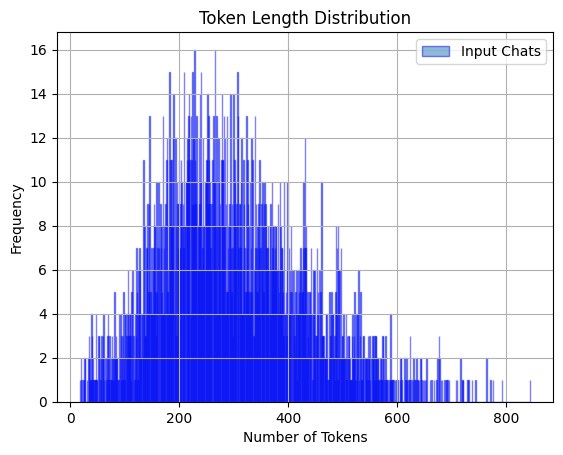

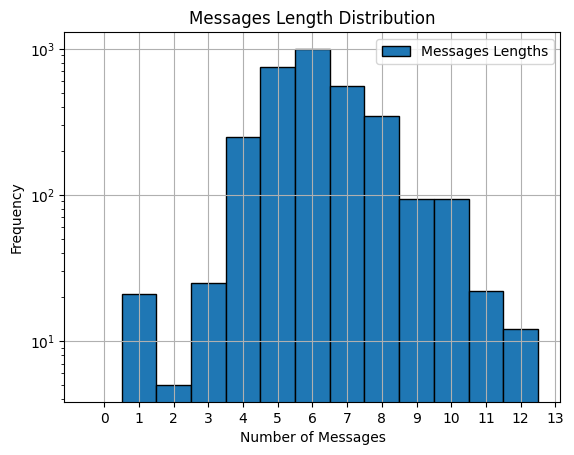

In [11]:
df = pd.DataFrame(tokenized_dataset)

more_than_1024_input_mask = df['input_ids'].apply(lambda x: len(x) > 1024)
more_than_512_input_mask = df['input_ids'].apply(lambda x: len(x) > 512)

# print(f"Tokenized dataset:\n{df.head()}")
print("input_ids token length statistics:")
print(f"Number of samples with more than 1024 tokens: {len(df[more_than_1024_input_mask])}")
print(f"Number of samples with more than 512 tokens: {len(df[more_than_512_input_mask])}")

# plots histograms for input_ids and labels with different colors in a single plot
# with semi-transparent bars in order to visualize overlaps
# with 1024 + 1 bins where the last bin is for samples with more than 1024 tokens

input_ds_token_lengths = df['input_ids'].apply(lambda x: len(x))

input_ds_token_lengths.hist(
    bins=input_ds_token_lengths.max(), 
    edgecolor='blue', alpha=0.5, 
    label='Input Chats'
)
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Token Length Distribution')
plt.legend()
# plt.savefig(os.path.join(OUT_DIR, "token_and_message_length_distribution.png"))
plt.show()

# min_msgs = df['msgs_lengths'].min()
max_msgs = df['msgs_lengths'].max()
df['msgs_lengths'].hist(
    bins=range(max_msgs + 1),  # +2 so last bin includes max
    edgecolor='black',
    label='Messages Lengths',
    align='left'
)
plt.xlabel('Number of Messages')
plt.ylabel('Frequency')
plt.title('Messages Length Distribution')
plt.legend()
# plt.savefig(os.path.join(OUT_DIR, "messages_length_distribution.png"))
plt.yscale('log')
plt.xticks(range(max_msgs + 1))
plt.show()

# Remove all samples with more than 1024 tokens in input_ids and labels
df = df[~more_than_512_input_mask]

# 📂 Dataset Splitting

In [12]:
from sklearn.model_selection import GroupShuffleSplit

print(f"Users in dataset: {df['user_ids'].nunique()}")
print(f"Dataset size: {len(df)}\n")

#['user_ids', 'msgs_lengths', 'input_ids', 'token_type_ids', 'attention_mask', 'labels']
df.drop(columns=['msgs_lengths'], inplace=True)

gss_test = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(gss_test.split(
    X=df[['input_ids', 'token_type_ids', 'attention_mask']], 
    y=df['labels'], 
    groups=df['user_ids']
))

test_df = df.iloc[test_idx].copy()
train_val_df = df.iloc[train_val_idx].copy()

gss_val = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, eval_idx = next(gss_val.split(
    X=train_val_df[['input_ids', 'token_type_ids', 'attention_mask']], 
    y=train_val_df['labels'], 
    groups=train_val_df['user_ids']
))

eval_df = train_val_df.iloc[eval_idx].copy()
train_df = train_val_df.iloc[train_idx].copy()

print(f"Train/Eval Set Size: {len(train_val_df)} ({len(train_val_df) / len(df) * 100:.2f}%)")
print(f"Couples in Train/Eval Set: {train_val_df['user_ids'].nunique()}")

print(f"\nTest Set Size: {len(test_df)} ({len(test_df) / len(df) * 100:.2f}%)")
print(f"Couples in Test Set: {test_df['user_ids'].nunique()}")

print(f"\nTrain Set Size: {len(train_df)} ({len(train_df) / len(df) * 100:.2f}%)")
print(f"Couples in Train Set: {train_df['user_ids'].nunique()}")

print(f"\nValidation Set Size: {len(eval_df)} ({len(eval_df) / len(df) * 100:.2f}%)")
print(f"Couples in Validation Set: {eval_df['user_ids'].nunique()}")

train_val_df = train_val_df.drop(columns=['user_ids'])
train_df = train_df.drop(columns=['user_ids'])
eval_df = eval_df.drop(columns=['user_ids'])
test_df = test_df.drop(columns=['user_ids'])

train_df = train_df.reset_index(drop=True)
eval_df = eval_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

tokenized_train_set = Dataset.from_pandas(train_df)
tokenized_eval_set = Dataset.from_pandas(eval_df)
tokenized_test_set = Dataset.from_pandas(test_df)

# Set the format to PyTorch tensors
tokenized_train_set.set_format("torch")
tokenized_test_set.set_format("torch")
tokenized_eval_set.set_format("torch")

print_dataset_info(tokenized_train_set)

Users in dataset: 111
Dataset size: 2932

Train/Eval Set Size: 2330 (79.47%)
Couples in Train/Eval Set: 88

Test Set Size: 602 (20.53%)
Couples in Test Set: 23

Train Set Size: 1870 (63.78%)
Couples in Train Set: 70

Validation Set Size: 460 (15.69%)
Couples in Validation Set: 18
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1870
})
labels: 2

input_ids: tensor([  102, 15509,  1587,  2009,  5552,  1307,   342,  1628,  3098,   103,
         5552,  1587,  2009, 15509,   697,  2685,   543,  1307,  1569,   697,
          722,   228,  1553, 10562,   153,   162,   742,   697,   103, 15509,
         1587,  8361,   697,  2869,  1307,  4027,  7399,   158,   572,  2351,
          480,  1332,   120,   141,   228,  1553,   120,  2781,   697,   694,
          617, 10651,  2014,   126,   480,  1332,   120,  2935,  2304,   171,
          290,  1632,   697,   103,  5552,  1587,  3135,  1307,  2275,   697,
         1544,   510,  1600,  3098,   313,  

# ⚙️ Training Settings

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(
    SELECTED_BERT_MODEL,
    num_labels=NUM_LABELS,
    problem_type="single_label_classification"
)
model.to(device)
print(f"✅ Loaded Model: {model.__class__.__name__}")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters()):,}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded Model: BertForSequenceClassification
Total Parameters: 109,929,987


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    f1_weighted = f1_score(labels, predictions, average='weighted', zero_division=0)
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)
    accuracy = accuracy_score(labels, predictions)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_weighted': f1_weighted,
    }

In [15]:
training_args = TrainingArguments(
    output_dir=OUT_DIR,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,

    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    learning_rate=LEARNING_RATE,
    # warmup_steps=20,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_PERCENTAGE,
    # logging_dir=f'{OUT_DIR}/logs',
    
    lr_scheduler_type="linear",
    # lr_scheduler_type="reduce_lr_on_plateau",
    # lr_scheduler_kwargs= {
    #     "factor": 0.5,        # Riduce il learning rate del 50% quando non migliora
    #     "patience": 4,        # Aspetta 4 valutazioni senza miglioramento
    #     "threshold": 5e-5,    # Soglia sensibile
    #     "mode": "max"
    # },

    # 🎯 STRATEGIE OTTIMIZZATE
    eval_strategy="epoch",           # ← Valuta ogni N steps (più controllo)
    # eval_steps=20,                   # ← Valuta ogni 45 steps (frequente ma non eccessivo circa 0.5 epoche) 
    save_strategy="epoch",           # ← Salva in base agli steps (stesso timing di eval)
    # save_steps=20,                   # ← Salva ogni 45 steps (stesso di eval_steps circa 0.5 epoche) 
    
    # 📊 LOGGING
    # logging_steps=20,                # ← Log ogni 25 steps (più frequente di save)
    report_to="none",
    logging_strategy="epoch",
    
    load_best_model_at_end=True,

    metric_for_best_model="f1_weighted",
    greater_is_better=True,
    save_total_limit=SAVE_TOTAL_LIMIT,

    dataloader_num_workers=NUM_WORKERS,
    fp16=torch.cuda.is_available(),       # Mixed precision se GPU disponibile
    group_by_length=True,                 # Raggruppa per lunghezza sequenza: incrementa efficienza training, 
    remove_unused_columns=True            # Rimuove colonne non utilizzate dal dataset come min_avg_polarity
)

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=14,     # ← Numero di valutazioni senza miglioramento prima di fermare il training
    early_stopping_threshold=0.0005 # Soglia minima di miglioramento per considerare un miglioramento
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_set,
    eval_dataset=tokenized_eval_set,
    # tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    # callbacks=[early_stopping_callback]
)

# 🤖 Baseline BERT

In [ ]:
os.makedirs(RESULTS_PATH, exist_ok=True)
with open(os.path.join(RESULTS_PATH, "baseline.txt"), "w") as f:
    predictions_output = trainer.predict(tokenized_test_set)
    preds = np.argmax(predictions_output.predictions, axis=1)
    labels = predictions_output.label_ids
    report = classification_report(
        labels, preds, zero_division=0,
        target_names=TARGET_NAMES
    )
    print(report)
    f.write(report)

              precision    recall  f1-score   support

       Toxic       0.00      0.00      0.00       255
     Neutral       0.38      0.14      0.21       185
     Healthy       0.27      0.88      0.41       162

    accuracy                           0.28       602
   macro avg       0.22      0.34      0.20       602
weighted avg       0.19      0.28      0.17       602



# 🤖 Fine-Tuned BERT

In [ ]:
trainer.train()

In [ ]:
# Plots Learning Curve
plot_losses(trainer.state.log_history, RESULTS_PATH)

In [ ]:
os.makedirs(RESULTS_PATH, exist_ok=True)
with open(os.path.join(RESULTS_PATH, "fine-tuned.txt"), "w") as f:
    predictions_output = trainer.predict(tokenized_test_set)
    preds = np.argmax(predictions_output.predictions, axis=1)
    labels = predictions_output.label_ids
    report = classification_report(
        labels, preds, zero_division=0,
        target_names=TARGET_NAMES
    )
    print(report)
    f.write(report)

In [ ]:
if os.path.exists("/kaggle"):
    shutil.make_archive(OUT_DIR, 'zip', OUT_DIR)
    shutil.rmtree(OUT_DIR)
    # os.remove(OUT_DIR + '.zip')